## SQLite Time Series Visualization

### 1. Introduction
This notebook demonstrates how to store time series data in SQLite and create insightful visualizations.

In [1]:
# Import required libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import random

# Configure visualization styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

### 2. Create SQLite Database with Time Series Data

In [2]:
# Create a connection to SQLite database
conn = sqlite3.connect('time_series.db')
cursor = conn.cursor()

# Create tables for storing time series data
cursor.execute('''
CREATE TABLE IF NOT EXISTS stock_prices (
    id INTEGER PRIMARY KEY,
    ticker TEXT NOT NULL,
    date TEXT NOT NULL,
    open REAL,
    high REAL,
    low REAL,
    close REAL,
    volume INTEGER,
    UNIQUE(ticker, date)
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS economic_indicators (
    id INTEGER PRIMARY KEY,
    indicator_name TEXT NOT NULL,
    date TEXT NOT NULL,
    value REAL,
    UNIQUE(indicator_name, date)
)
''')

# Generate sample time series data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
indicators = ['GDP Growth', 'Unemployment Rate', 'Inflation Rate', 'Interest Rate']

# Generate 5 years of daily stock data
start_date = datetime(2020, 1, 1)
end_date = datetime(2025, 1, 1)
delta = timedelta(days=1)

stock_data = []
current_date = start_date
stock_prices = {ticker: 100 + random.randint(-20, 50) for ticker in tickers}

while current_date < end_date:
    # Skip weekends
    if current_date.weekday() < 5:  # 0-4 represents Monday to Friday
        for ticker in tickers:
            # Random daily change with 0.5% average volatility
            daily_change = np.random.normal(0.0005, 0.015)
            current_price = stock_prices[ticker] * (1 + daily_change)
            stock_prices[ticker] = current_price

            # Generate OHLC data
            daily_volatility = current_price * 0.01
            open_price = current_price
            close_price = current_price * (1 + np.random.normal(0, 0.005))
            high_price = max(open_price, close_price) + abs(np.random.normal(0, daily_volatility))
            low_price = min(open_price, close_price) - abs(np.random.normal(0, daily_volatility))
            volume = int(abs(np.random.normal(1000000, 300000)))

            stock_data.append((
                ticker,
                current_date.strftime('%Y-%m-%d'),
                open_price,
                high_price,
                low_price,
                close_price,
                volume
            ))

    current_date += delta

# Insert stock data in batches
conn.execute('BEGIN TRANSACTION')
for i in range(0, len(stock_data), 1000):
    batch = stock_data[i:i+1000]
    cursor.executemany(
        'INSERT OR REPLACE INTO stock_prices (ticker, date, open, high, low, close, volume) VALUES (?, ?, ?, ?, ?, ?, ?)',
        batch
    )
conn.execute('COMMIT')

# Generate monthly economic indicators
economic_data = []
current_date = start_date.replace(day=1)

# Initial values
indicator_values = {
    'GDP Growth': 2.5,
    'Unemployment Rate': 5.0,
    'Inflation Rate': 2.0,
    'Interest Rate': 1.5
}

while current_date < end_date:
    for indicator in indicators:
        # Update with some randomness and trends
        if indicator == 'GDP Growth':
            change = np.random.normal(0, 0.3)
        elif indicator == 'Unemployment Rate':
            change = np.random.normal(0, 0.2)
        elif indicator == 'Inflation Rate':
            change = np.random.normal(0, 0.1)
        else:  # Interest Rate
            change = np.random.normal(0, 0.05)

        indicator_values[indicator] += change

        # Add some constraints to keep values realistic
        if indicator == 'Unemployment Rate' and indicator_values[indicator] < 2:
            indicator_values[indicator] = 2
        if indicator == 'Inflation Rate' and indicator_values[indicator] < 0:
            indicator_values[indicator] = 0
        if indicator == 'Interest Rate' and indicator_values[indicator] < 0:
            indicator_values[indicator] = 0

        economic_data.append((
            indicator,
            current_date.strftime('%Y-%m-%d'),
            indicator_values[indicator]
        ))

    # Move to next month
    month = current_date.month + 1
    year = current_date.year
    if month > 12:
        month = 1
        year += 1
    current_date = current_date.replace(year=year, month=month)

# Insert economic data
cursor.executemany(
    'INSERT OR REPLACE INTO economic_indicators (indicator_name, date, value) VALUES (?, ?, ?)',
    economic_data
)

conn.commit()
print("Database populated with sample time series data")

Database populated with sample time series data


### 3. Basic Time Series Visualization
#### 3.1 Stock Price Line Chart

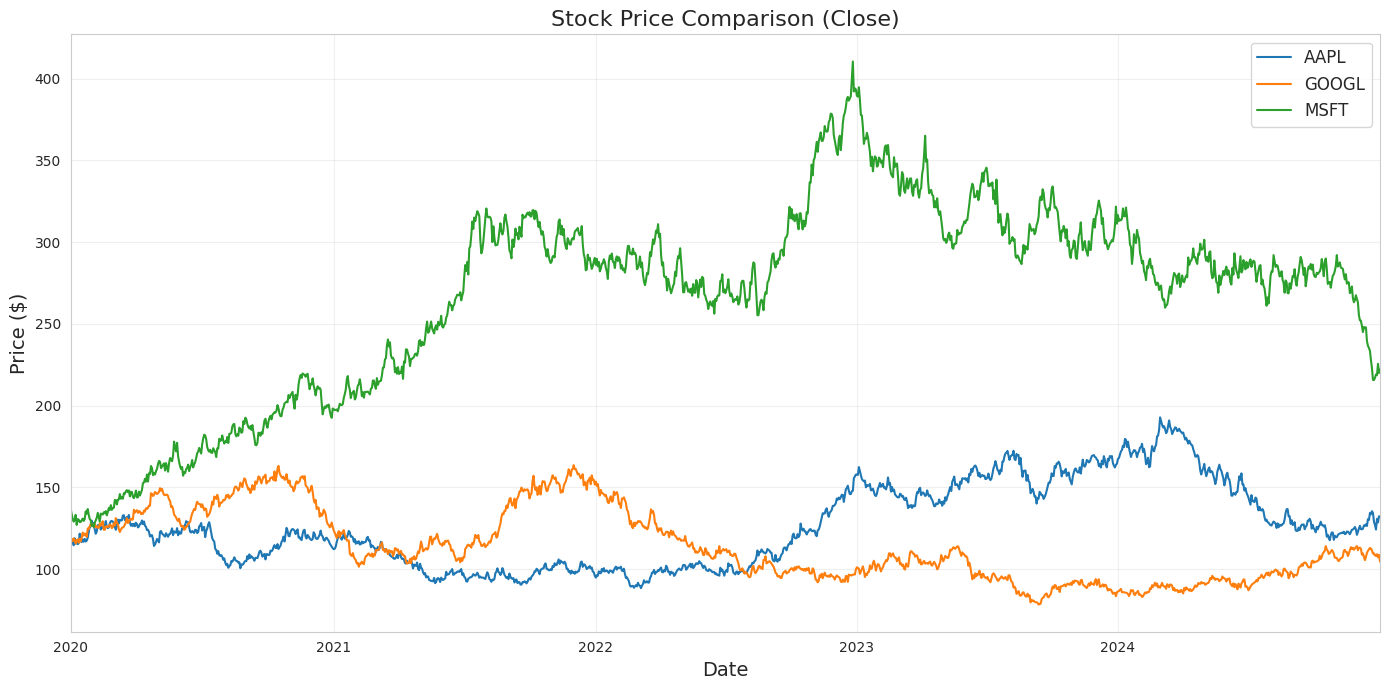

In [3]:
# Query stock price data
query = """
SELECT ticker, date, close
FROM stock_prices
WHERE ticker IN ('AAPL', 'MSFT', 'GOOGL')
ORDER BY date
"""
df_stocks = pd.read_sql_query(query, conn)

# Convert date to datetime
df_stocks['date'] = pd.to_datetime(df_stocks['date'])

# Pivot the data for plotting
pivot_stocks = df_stocks.pivot(index='date', columns='ticker', values='close')

# Plot with Matplotlib
plt.figure(figsize=(14, 7))
pivot_stocks.plot(ax=plt.gca())
plt.title('Stock Price Comparison (Close)', fontsize=16)
plt.ylabel('Price ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('stock_comparison.png', dpi=300)
plt.show()

# Interactive plot with Plotly
fig = px.line(
    df_stocks,
    x='date',
    y='close',
    color='ticker',
    title='Interactive Stock Price Comparison'
)
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price ($)',
    legend_title='Ticker',
    hovermode='x unified'
)
fig.show()

#### 3.2 Economic Indicators Subplot

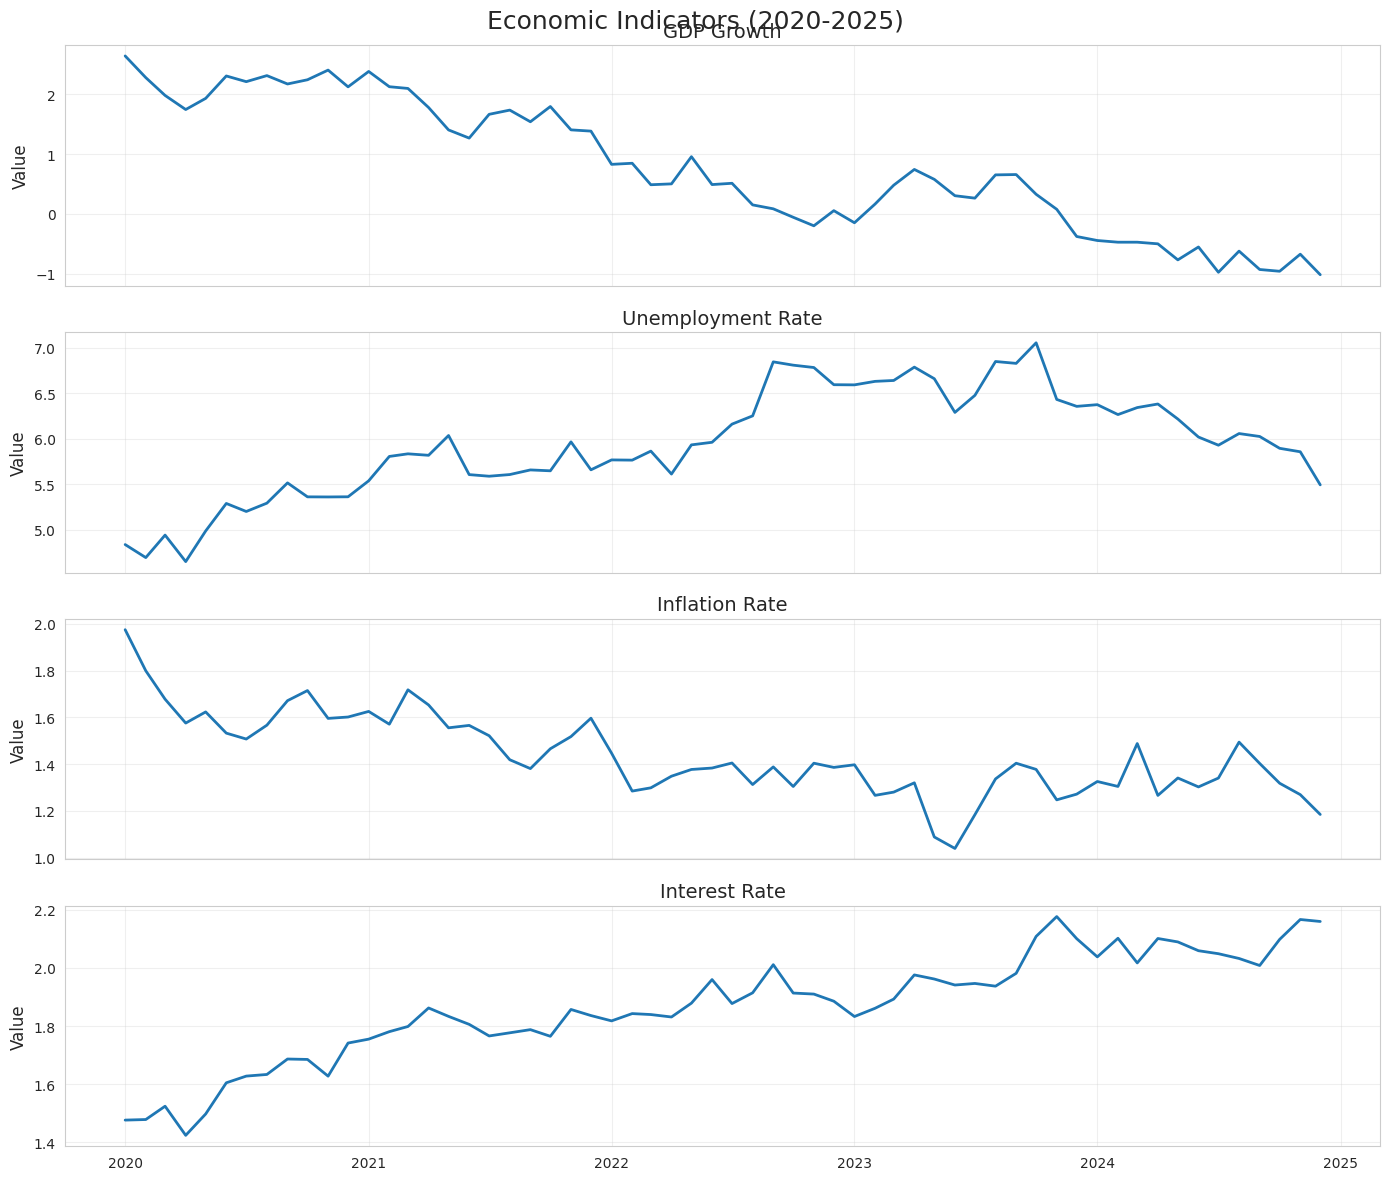

In [4]:
# Query economic indicators
query = """
SELECT indicator_name, date, value
FROM economic_indicators
ORDER BY date
"""
df_econ = pd.read_sql_query(query, conn)

# Convert date to datetime
df_econ['date'] = pd.to_datetime(df_econ['date'])

# Create separate dataframes for each indicator
indicators = df_econ['indicator_name'].unique()
indicator_dfs = {}

for indicator in indicators:
    indicator_dfs[indicator] = df_econ[df_econ['indicator_name'] == indicator].copy()

# Create subplots
fig, axes = plt.subplots(len(indicators), 1, figsize=(14, 12), sharex=True)
fig.suptitle('Economic Indicators (2020-2025)', fontsize=18)

for i, indicator in enumerate(indicators):
    df = indicator_dfs[indicator]
    axes[i].plot(df['date'], df['value'], linewidth=2)
    axes[i].set_title(indicator, fontsize=14)
    axes[i].set_ylabel('Value', fontsize=12)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('economic_indicators.png', dpi=300)
plt.show()

### 4. Advanced Time Series Visualizations
#### 4.1 Candlestick Chart

In [5]:
# Query OHLC data for AAPL for the last 90 days
query = """
SELECT date, open, high, low, close, volume
FROM stock_prices
WHERE ticker = 'AAPL'
ORDER BY date DESC
LIMIT 90
"""
df_ohlc = pd.read_sql_query(query, conn)
df_ohlc['date'] = pd.to_datetime(df_ohlc['date'])
df_ohlc.sort_values('date', inplace=True)

# Create candlestick chart with Plotly
fig = go.Figure(data=[go.Candlestick(
    x=df_ohlc['date'],
    open=df_ohlc['open'],
    high=df_ohlc['high'],
    low=df_ohlc['low'],
    close=df_ohlc['close'],
    name='AAPL'
)])

fig.update_layout(
    title='AAPL Stock Price (Candlestick - Last 90 Days)',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)
fig.show()

#### 4.2 Volume Profile

In [6]:
# Create volume bar chart below the candlestick
fig = go.Figure()

# Add candlestick
fig.add_trace(go.Candlestick(
    x=df_ohlc['date'],
    open=df_ohlc['open'],
    high=df_ohlc['high'],
    low=df_ohlc['low'],
    close=df_ohlc['close'],
    name='AAPL Price'
))

# Add volume bars
fig.add_trace(go.Bar(
    x=df_ohlc['date'],
    y=df_ohlc['volume'],
    name='Volume',
    marker=dict(color='rgba(100, 100, 255, 0.5)')
))

# Create secondary y-axis for volume
fig.update_layout(
    title='AAPL Stock Price and Volume',
    yaxis_title='Price',
    yaxis2=dict(
        title='Volume',
        overlaying='y',
        side='right'
    ),
    xaxis_rangeslider_visible=False
)

# Set y-axis 2 for the volume trace
fig.data[1].update(yaxis='y2')
fig.show()

#### 4.3 Correlation Heatmap

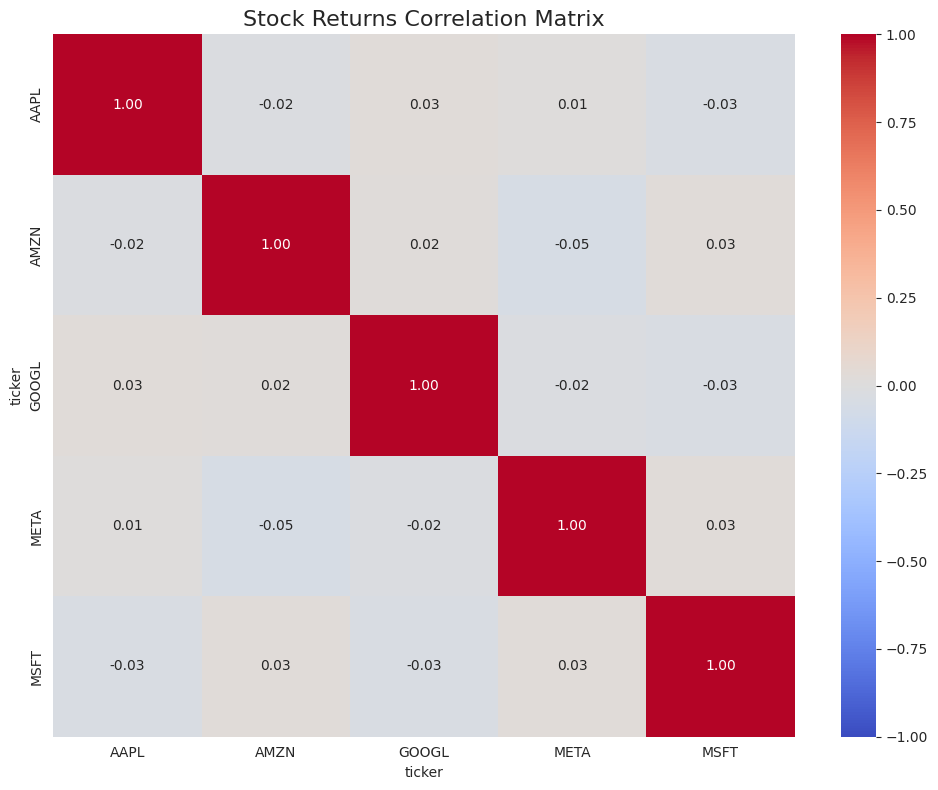

In [7]:
# Get all stock closes
query = """
SELECT ticker, date, close
FROM stock_prices
ORDER BY date
"""
df_all_stocks = pd.read_sql_query(query, conn)
df_all_stocks['date'] = pd.to_datetime(df_all_stocks['date'])

# Pivot for correlation analysis
pivot_all = df_all_stocks.pivot(index='date', columns='ticker', values='close')

# Calculate daily returns
returns = pivot_all.pct_change().dropna()

# Calculate correlation
correlation = returns.corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Stock Returns Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

### 5. Time Series Forecasting Visualization

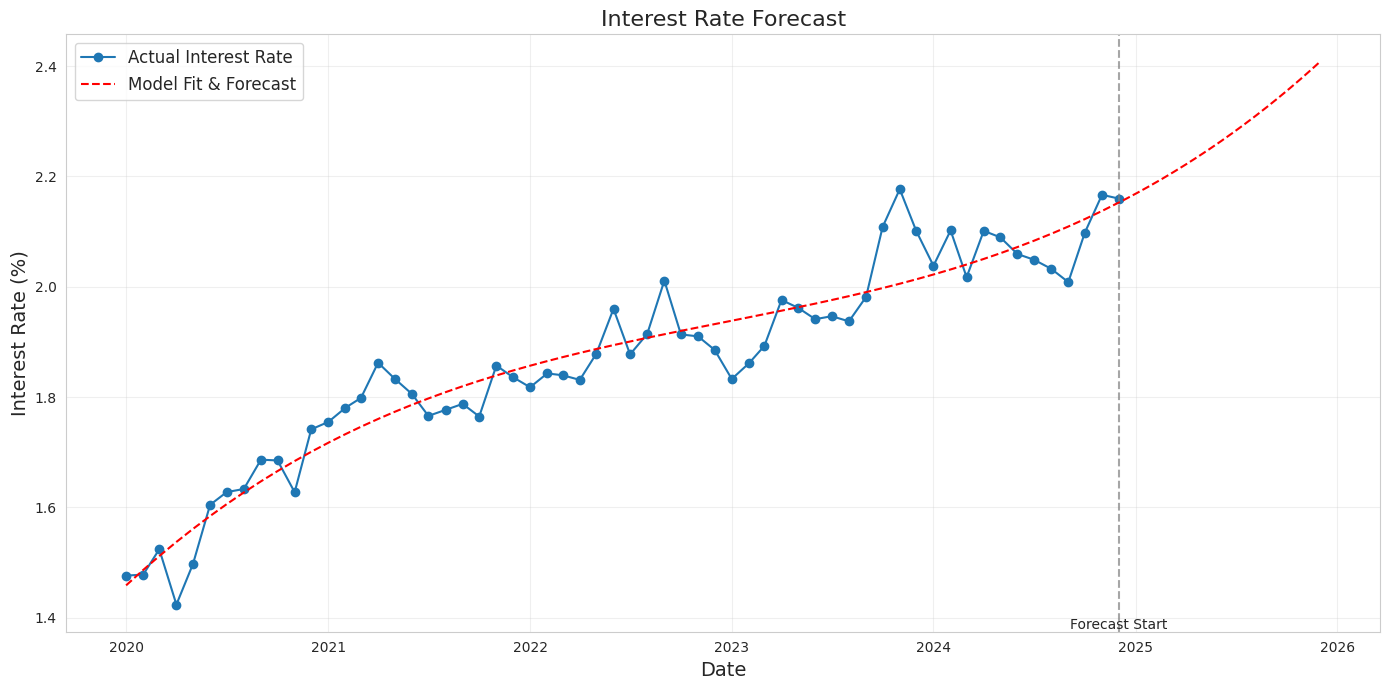

In [8]:
# Use scikit-learn for a simple forecasting example
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Get interest rate data
interest_data = indicator_dfs['Interest Rate'].copy()

# Create features (days since start)
interest_data['days'] = (interest_data['date'] - interest_data['date'].min()).dt.days
interest_data['actual'] = interest_data['value']

# Create polynomial features
X = interest_data['days'].values.reshape(-1, 1)
y = interest_data['value'].values

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# Train a model
model = LinearRegression()
model.fit(X_poly, y)

# Predict on existing data
interest_data['predicted'] = model.predict(X_poly)

# Predict future values (extend 365 days into the future)
future_days = np.arange(interest_data['days'].max() + 1, interest_data['days'].max() + 366)
X_future = poly.transform(future_days.reshape(-1, 1))
future_predictions = model.predict(X_future)

# Create future dates
last_date = interest_data['date'].max()
future_dates = [last_date + timedelta(days=i+1) for i in range(len(future_days))]

# Create future dataframe
future_df = pd.DataFrame({
    'date': future_dates,
    'days': future_days,
    'predicted': future_predictions
})

# Combine actual and future
forecast_df = pd.concat([
    interest_data[['date', 'days', 'actual', 'predicted']],
    future_df
])

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(interest_data['date'], interest_data['actual'], 'o-', label='Actual Interest Rate')
plt.plot(forecast_df['date'], forecast_df['predicted'], '--', color='red', label='Model Fit & Forecast')

# Add a vertical line at the forecast start
plt.axvline(x=interest_data['date'].max(), color='gray', linestyle='--', alpha=0.7)
plt.text(interest_data['date'].max(), plt.ylim()[0], 'Forecast Start', ha='center', va='bottom')

plt.title('Interest Rate Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Interest Rate (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('interest_rate_forecast.png', dpi=300)
plt.show()